<a href="https://colab.research.google.com/github/Amrutha2294/Project/blob/main/U_Net_with_Pretrained_MobileNetV2_as_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net with Pretrained MobileNetV2 as Encoder

## What is U-Net
Paper: <a href="https://arxiv.org/abs/1505.04597"> https://arxiv.org/abs/1505.04597 </a>

U-Net is a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg, Germany. The network is based on the fully convolutional network and its architecture was modified and extended to work with fewer training images and to yield more precise segmentations.

<img src="images/u-net-architecture.png">

<br/>
UNet Architecture has 3 parts:
<ol>
    <li>The Contracting/Downsampling Path</li>
    <li>Bottleneck</li>
    <li>The Expanding/Upsampling Path</li>
</ol>

<h3>Downsampling Path: </h3>
 <ul>
    <li>It consists of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling.</li>
    <li>At each downsampling step we double the number of feature channels.</li>
</ul>

<h3>Upsampling Path: </h3>
<ul>
    <li> Every  step  in  the  expansive  path  consists  of  an  upsampling  of  the feature map followed by a 2x2 convolution (“up-convolution”), a concatenation with the correspondingly feature  map  from  the  downsampling  path,  and  two  3x3  convolutions,  each  followed by a ReLU.</li>
</ul>

<h3> Skip Connection: </h3>
The skip connection from the downsampling path are concatenated with feature map during upsampling path. These skip connection provide local information to global information while upsampling.

<h3> Final Layer: </h3>
At the final layer a 1x1 convolution is used to map each feature vector to the desired number of classes.
<br/> <br/> <br/>
<hr>

## What is MobileNetV2
Paper: <a href="https://arxiv.org/pdf/1801.04381.pdf"> https://arxiv.org/pdf/1801.04381.pdf </a>

MobileNetV2 is a architecture that is optimized for mobile devices. It improves the state of the art performance of mobile models on multiple tasks and benchmarks as well as across a spectrum of different model
sizes.

<img src="images/MobileNetV2 architecture.png" style="height:400px; ">

The MobileNetV2 is used for the encoder/downsampling path of the U-Net (the left half of the U)
<br/> <br/> <br/>
<hr>

## What are the Advantages of using a MobileNetV2 as Pretrained Encoder

<ul>
    <li> MobileNetV2 has less parameters, due to which it is easy to train. </li>
    <li> Using a pretrained encoder helps the model to converge much faster in comparison to the non-pretrained model. </li>
    <li> A pretrained encoder helps the model to achieve high performance as compared to non-pretrained model.</li>
</ul>
<br/>
<hr>

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Change according to your directory structure
!ls /content/drive/'My Drive'/DSProject

test.jpg  VOC2012.zip


In [14]:
# Change according to your directory structure
!cp /content/drive/'My Drive'/DSProject/VOC2012.zip .
!unzip -q -o VOC2012.zip
!rm VOC2012.zip
!ls

drive  sample_data  VOCtrainval_11-May-2012


## Importing Libraries and Functions

In [23]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [24]:
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.5.0


Seeding

In [25]:
np.random.seed(42)
tf.random.set_seed(42)

## Hyperparameters

In [26]:
IMAGE_SIZE = 256
EPOCHS = 30
BATCH = 8
LR = 1e-4

PATH = "./VOCtrainval_11-May-2012/VOCdevkit/VOC2012/ImageSets/Segmentation/"

In [27]:
PATH

'./VOCtrainval_11-May-2012/VOCdevkit/VOC2012/ImageSets/Segmentation/'

## Dataset
You can download the dataset from <a href="https://polyp.grand-challenge.org/CVCClinicDB/">here</a> or from directly from the <a href="https://www.dropbox.com/s/p5qe9eotetjnbmq/CVC-ClinicDB.rar?dl=0">Dropbox</a>.

<br/>
Spliting the data into training, validation and testing with 80:10:10 ratio.

In [28]:
# def load_data(path, split=0.1):
#     images = sorted(glob(os.path.join(path, "images/*")))
#     masks = sorted(glob(os.path.join(path, "masks/*")))

#     total_size = len(images)
#     valid_size = int(split * total_size)
#     test_size = int(split * total_size)

#     train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
#     train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

#     train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
#     train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

#     return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [29]:
# Replaced the data loading function

def load_data(path,is_train = True):
  im_path =[]
  l_path =[]
  images = os.path.join(path,"./VOCtrainval_11-May-2012","VOCdevkit","VOC2012","ImageSets","Segmentation","train.txt" if is_train else "val.txt")
  with open(images,"r") as file_:
    Instances = file_.read().split()

    for img in Instances:
      path_img = os.path.join(path,"VOCtrainval_11-May-2012","VOCdevkit","VOC2012","JPEGImages",img+".jpg")
      path_label = os.path.join(path,"VOCtrainval_11-May-2012","VOCdevkit","VOC2012","SegmentationClass",img+".png")
      im_path.append(path_img)
      l_path.append(path_label)
  return (im_path,l_path)
  

Reading the images and masks

In [30]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

Building the tf.data pipeline for training, validation and testing dataset.

In [31]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [32]:
#(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)
path = ''
(train_x, train_y)= load_data(path=path,is_train=True)
(valid_x, valid_y) =load_data(path=path,is_train=False)



print("Training data: ", len(train_y))
print("Validation data: ", len(valid_y))


Training data:  1464
Validation data:  1449


In [33]:

def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

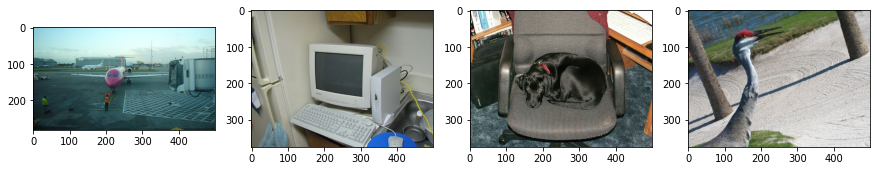

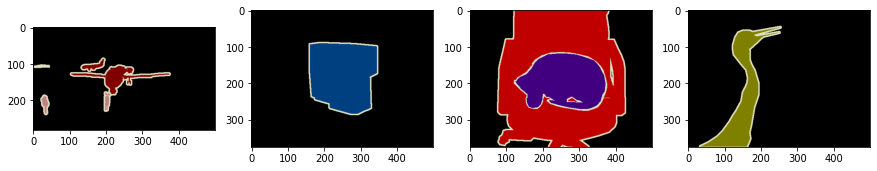

In [34]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

## Model

In [ ]:
# tf.keras.applications.MobileNetV2(
#     input_shape=None, alpha=1.0, include_top=True, weights='imagenet',
#     input_tensor=None, pooling=None, classes=1000,
#     classifier_activation='softmax', **kwargs
# )
# tf.keras.applications.ResNet50(
#     include_top=False, weights='imagenet', input_tensor=None,
#     input_shape=None, pooling=None, classes=1000, **kwargs
# )

In [44]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    encoder = ResNet50(input_tensor=inputs, weights="imagenet", include_top=False)
    encoder.summary()

    skip_connection_names = ["input_image", "conv1_relu", "conv2_block3_out", "conv3_block4_out"]
    encoder_output = encoder.get_layer("conv4_block6_out").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
         x_skip = encoder.get_layer(skip_connection_names[-i]).output
         x = UpSampling2D((2, 2))(x)
         x = Concatenate()([x, x_skip])

         x = Conv2D(f[-i], (3, 3), padding="same")(x)
         x = BatchNormalization()(x)
         x = Activation("relu")(x)
        
         x = Conv2D(f[-i], (3, 3), padding="same")(x)
         x = BatchNormalization()(x)
         x = Activation("relu")(x)
        
    x = Conv2D(21, (1, 1), padding="same")(x)
    x = Activation("softmax")(x)
    
    model = Model(inputs, x)
    return model

In [40]:
model()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [37]:
# def model():
#     inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
#     encoder = ResNet50(input_tensor=inputs, weights="imagenet", include_top=False)
#     skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
#     encoder_output = encoder.get_layer("block_13_expand_relu").output
    
#     f = [16, 32, 48, 64]
#     x = encoder_output
#     for i in range(1, len(skip_connection_names)+1, 1):
#         x_skip = encoder.get_layer(skip_connection_names[-i]).output
#         x = UpSampling2D((2, 2))(x)
#         x = Concatenate()([x, x_skip])
        
#         x = Conv2D(f[-i], (3, 3), padding="same")(x)
#         x = BatchNormalization()(x)
#         x = Activation("relu")(x)
        
#         x = Conv2D(f[-i], (3, 3), padding="same")(x)
#         x = BatchNormalization()(x)
#         x = Activation("relu")(x)
        
#     x = Conv2D(1, (1, 1), padding="same")(x)
#     x = Activation("sigmoid")(x)
    
#     model = Model(inputs, x)
#     return model

In [45]:
model = model()
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## Metrics

In [46]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

## Training

In [47]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

In [48]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [49]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [50]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/30
 81/183 [============>.................] - ETA: 17:23 - loss: 0.7707 - dice_coef: 0.2293 - recall: 1.0000 - precision: 0.2916

KeyboardInterrupt: ignored

## Evaluation

In [ ]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

model.evaluate(test_dataset, steps=test_steps)

## Results

In [ ]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [ ]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

In [ ]:
for i, (x, y) in enumerate(zip(test_x[:10], test_y[:10])):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)

## How to Improve the Results

<ul>
    <li> Use data augmentation </li>
    <li> Use other pretrained encoder </li>
    <li> Use a different decoder or different blocks in the decoder. </li>   
 </ul>

# Thank You

FOLLOW US ON:
<ul>
<li><a href="https://www.youtube.com/idiotdeveloper"> YOUTUBE </a></li>
<li><a href="https://facebook.com/idiotdeveloper"> FACEBOOK </a></li>
<li><a href="https://twitter.com/nikhilroxtomar"> TWITTER </a></li>
<li><a href="https://www.instagram.com/nikhilroxtomar"> INSTAGRAM </a></li>
<li><a href="https://www.patreon.com/idiotdeveloper"> PATREON </a></li>
</ul>